In [22]:
!pip install tensorflow==2.16.1



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


# Gerekli Modüllerin Import Edilmesi

In [23]:
import os 
import itertools
from PIL import Image
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam , Adamax

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16 ,EfficientNetB7 ,ResNet50

from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 


# TPU entegre etme
try:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  print("All devices: ", tf.config.list_logical_devices('TPU'))
  strategy = tf.distribute.experimental.TPUStrategy(resolver)
except ValueError:
  strategy = tf.distribute.get_strategy() 

print('modules loaded')

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: local


INFO:tensorflow:Initializing the TPU system: local


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]
INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


modules loaded


# Dataframe Oluşturma

In [24]:

# directory paths
# base_dir değişkeni, eğitim verilerinin bulunduğu temel dizini tanımlar.
base_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'
# NORMAL_dir değişkeni, (NORMAL) görüntülerinin bulunduğu alt dizini tanımlar.
NORMAL_dir = os.path.join(base_dir, 'NORMAL')
# PNEUMONIA_dir değişkeni,(PNEUMONIA) görüntülerinin bulunduğu alt dizini tanımlar.
PNEUMONIA_dir = os.path.join(base_dir, 'PNEUMONIA')

# file_paths listesi, tüm görüntü dosyalarının tam yolunu depolayacaktır.
file_paths = []
# labels listesi, her görüntü dosyasına karşılık gelen etiketleri (NORMAL veya PNEUMONIA) depolayacaktır.
labels = []

# iyi huylu (NORMAL) görüntü dosyalarının yolları ve etiketleri eklenir.
# os.listdir(NORMAL_dir) fonksiyonu, NORMAL_dir dizinindeki tüm dosya ve dizin isimlerini bir liste olarak döndürür.
for filename in os.listdir(NORMAL_dir):
    # if koşulu, yalnızca .jpeg veya .png uzantılı dosyaları işler.
    if filename.endswith('.jpeg') or filename.endswith('.png'): 
        # os.path.join(NORMAL_dir, filename) fonksiyonu, NORMAL_dir dizini ile filename'i birleştirerek tam dosya yolunu oluşturur.
        file_paths.append(os.path.join(NORMAL_dir, filename))
        # 'NORMAL' etiketi, file_paths listesine eklenen dosya için labels listesine eklenir.
        labels.append('NORMAL')

# kötü huylu (PNEUMONIA) görüntü dosyalarının yolları ve etiketleri eklenir.
# Bu kısım, NORMAL görüntüler için yapılan işlemlerin aynısını PNEUMONIA görüntüler için tekrarlar.
for filename in os.listdir(PNEUMONIA_dir):
    if filename.endswith('.jpeg') or filename.endswith('.png'):  
        file_paths.append(os.path.join(PNEUMONIA_dir, filename))
        labels.append('PNEUMONIA')

# DataFrame oluşturma
# pandas kütüphanesinden DataFrame oluşturulur.
# 'file_path' sütunu, file_paths listesinden alınan görüntü dosya yollarını içerir.
# 'label' sütunu, labels listesinden alınan etiketleri içerir.
train_df = pd.DataFrame({
    'file_path': file_paths,
    'label': labels
})

In [25]:
train_df.head() #ilk 5 satırı gösterir

,file_path,label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL


In [26]:
train_df.shape

(624, 2)

In [27]:
# Test veri seti için temel dizin
base_test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'
# (NORMAL) test görüntülerinin bulunduğu alt dizin
NORMAL_test_dir = os.path.join(base_test_dir, 'NORMAL')
# (PNEUMONIA) test görüntülerinin bulunduğu alt dizin
PNEUMONIA_test_dir = os.path.join(base_test_dir, 'PNEUMONIA')

# Test dosya yolları ve etiketleri için boş listeler
test_file_paths = []
test_labels = []

# (NORMAL) test görüntülerinin yolları ve etiketleri eklenir.
for filename in os.listdir(NORMAL_test_dir):
    if filename.endswith('.jpeg') or filename.endswith('.png'):  
        # Tam dosya yolu oluşturulur ve listeye eklenir
        test_file_paths.append(os.path.join(NORMAL_test_dir, filename))
        # 'NORMAL' etiketi listeye eklenir
        test_labels.append('NORMAL')

# (PNEUMONIA) test görüntülerinin yolları ve etiketleri eklenir.
for filename in os.listdir(PNEUMONIA_test_dir):
    if filename.endswith('.jpeg') or filename.endswith('.png'):  
        # Tam dosya yolu oluşturulur ve listeye eklenir
        test_file_paths.append(os.path.join(PNEUMONIA_test_dir, filename))
        # 'PNEUMONIA' etiketi listeye eklenir
        test_labels.append('PNEUMONIA')

# Test verilerini içeren DataFrame oluşturulur
test_df = pd.DataFrame({
    'file_path': test_file_paths,
    'label': test_labels
})

In [28]:
test_df.head()

,file_path,label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL


In [29]:
test_df.shape

(624, 2)

# 

# Bazı Görüntülerin Gösterilmesi

In [30]:
# DataFrame'den belirli bir etiketle görüntüler göstermek için bir fonksiyon tanımlar
def display_sample_images(df, label, num_images=5):
    # DataFrame'i verilen etiketle filtreler
    label_df = df[df['label'] == label]
    
    # Etiketli DataFrame'den rastgele num_images sayıda örnek seçer
    sample_df = label_df.sample(num_images, random_state=1)
    
    # Görüntülerin gösterileceği bir figür oluşturur
    plt.figure(figsize=(15, 5))
    
    # Seçilen örnekleri döngü ile işler
    for i, (index, row) in enumerate(sample_df.iterrows()):
        # Görüntüyü dosya yolundan okur
        img = mpimg.imread(row['file_path'])
        # Alt grafik oluşturur
        plt.subplot(1, num_images, i + 1)
        # Görüntüyü alt grafike yazar
        plt.imshow(img)
        # Eksenleri gizler
        plt.axis('off')
        # Alt grafiğe etiket ekler
        plt.title(label)
    
    # Tüm grafikleri gösterir
    plt.show()

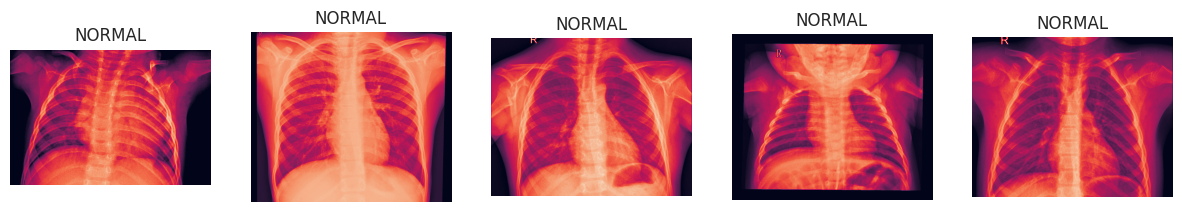

In [31]:
display_sample_images(train_df, 'NORMAL')

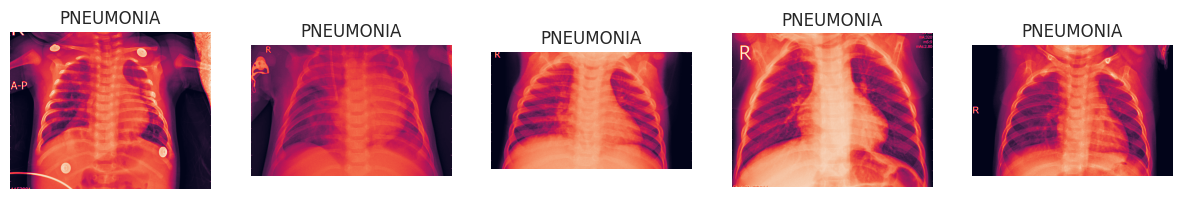

In [32]:
display_sample_images(train_df, 'PNEUMONIA')

In [33]:
train_df.describe(include='all')


,file_path,label
count,624,624
unique,624,2
top,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
freq,1,390


In [34]:
test_df.describe(include='all')

,file_path,label
count,624,624
unique,624,2
top,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
freq,1,390


In [35]:
print("\nClass distribution in train_df:")
train_df['label'].value_counts()


Class distribution in train_df:


label
PNEUMONIA    390
NORMAL       234
Name: count, dtype: int64

In [36]:
print("\nClass distribution in test_df:")
test_df['label'].value_counts()


Class distribution in test_df:


label
PNEUMONIA    390
NORMAL       234
Name: count, dtype: int64

# Verileri Bölme

In [37]:
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'])

# Veri artırma dönüşümlerini tanımlama

In [38]:
# Eğitim verileri için ImageDataGenerator oluşturulur
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Piksel değerlerini 0 ile 1 arasında ölçeklendirir
    rotation_range=40,  # Görüntüleri rastgele 40 dereceye kadar döndürür
    width_shift_range=0.2,  # Görüntüleri yatay olarak %20'ye kadar kaydırır
    height_shift_range=0.2,  # Görüntüleri dikey olarak %20'ye kadar kaydırır
    shear_range=0.2,  # Rastgele kesme dönüşümleri uygular
    zoom_range=0.2,  # Görüntüleri %20'ye kadar yakınlaştırır veya uzaklaştırır
    horizontal_flip=True,  # Görüntüleri rastgele yatay olarak çevirir
    fill_mode='nearest'  # Yeni pikselleri en yakın pikselin değeriyle doldurur
)

# Doğrulama verileri için ImageDataGenerator oluşturulur (sadece ölçeklendirme uygulanır)
val_datagen = ImageDataGenerator(rescale=1./255)

# Test verileri için ImageDataGenerator oluşturulur (sadece ölçeklendirme uygulanır)
test_datagen = ImageDataGenerator(rescale=1./255)

In [39]:
# Eğitim verilerini ImageDataGenerator kullanarak yükler
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,  # Eğitim DataFrame'i
    x_col='file_path',  # Görüntü dosya yolları sütunu
    y_col='label',  # Etiket sütunu
    target_size=(300, 300),  # Görüntülerin yeniden boyutlandırılması için hedef boyut
    batch_size=16,  # Her adımda işlenecek örnek sayısı
    class_mode='binary',  # İki sınıflı sınıflandırma için etiket formatı
    color_mode='rgb'  # Görüntülerin renkli olarak yüklenmesi
)

# Doğrulama verilerini ImageDataGenerator kullanarak yükler
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,  # Doğrulama DataFrame'i
    x_col='file_path',
    y_col='label',
    target_size=(300, 300),
    batch_size=16,
    class_mode='binary',
    color_mode='rgb'
)

# Test verilerini ImageDataGenerator kullanarak yükler
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,  # Test DataFrame'i
    x_col='file_path',
    y_col='label',
    target_size=(300, 300),
    batch_size=16,
    class_mode='binary',
    color_mode='rgb'
)

Found 499 validated image filenames belonging to 2 classes.
Found 125 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


# Modeli Oluşturma

In [40]:
with strategy.scope():
    # Define the model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(300, 300, 3))
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Fit the model
    history = model.fit(train_generator,
                        steps_per_epoch=train_generator.samples // train_generator.batch_size,
                        epochs=100,
                        validation_data=val_generator,
                        validation_steps=val_generator.samples // val_generator.batch_size)


Epoch 1/100


2024-08-12 07:00:47.104793: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
/usr/local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1723446050.230729    8414 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(c09c775c9fc74b28:0:0), session_name()


 4/31 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6901 - loss: 0.6533 

I0000 00:00:1723446056.189447    8414 tpu_compile_op_common.cc:245] Compilation of c09c775c9fc74b28:0:0 with session name  took 5.958668499s and succeeded
I0000 00:00:1723446056.191875    8414 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(c09c775c9fc74b28:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_7320228667750060866", property.function_library_fingerprint = 3324620106182242524, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,300,300,3,;2,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1723446056.191907    8414 tpu_compilation_cache_interface.cc:541] After adding entry for key c09c

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.6079 - loss: nan

I0000 00:00:1723446065.285546    8427 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(9433dfcbc35cb6f6:0:0), session_name()
I0000 00:00:1723446070.306569    8427 tpu_compile_op_common.cc:245] Compilation of 9433dfcbc35cb6f6:0:0 with session name  took 5.020964855s and succeeded
I0000 00:00:1723446070.309429    8427 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(9433dfcbc35cb6f6:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_14039241896884575290", property.function_library_fingerprint = 17785019612039860656, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,300,300,3,;2,;", property.guaranteed_constants_size = 0, embedd

31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 476ms/step - accuracy: 0.6069 - loss: nan - val_accuracy: 0.6429 - val_loss: 0.6722
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5121 - loss: 0.6577 - val_accuracy: 1.0000 - val_loss: 0.5420
Epoch 3/100


/usr/local/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 343ms/step - accuracy: 0.6063 - loss: nan - val_accuracy: 0.4286 - val_loss: 0.8210
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0161 - loss: 1.1119 - val_accuracy: 1.0000 - val_loss: 0.3933
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 355ms/step - accuracy: 0.6282 - loss: nan - val_accuracy: 0.6429 - val_loss: 0.6598
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5060 - loss: 0.7699 - val_accuracy: 1.0000 - val_loss: 0.3231
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 348ms/step - accuracy: 0.6394 - loss: nan - val_accuracy: 0.7143 - val_loss: 0.5684
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.3707 - val_accuracy: 1.0000 - val_loss: 0.3677
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 14s 353ms/step - accuracy: 0.6224 - loss: nan - val_accuracy: 0.6429 - val_loss: 0.6333
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5020 - loss: 0.7378 - val_accuracy: 1.0000 - val_loss: 0.

# Modeli değerlendirme

In [41]:
# Test verileri üzerinde modeli değerlendirir
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
# Test doğruluk değerini yazdırır
print(f'Test accuracy: {test_accuracy}')

2024-08-12 07:12:45.236646: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignVariableOp.


39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.8402 - loss: 0.4751
Test accuracy: 0.8717948794364929


# Eğitim ve doğrulama doğruluk değerlerini çizdirme

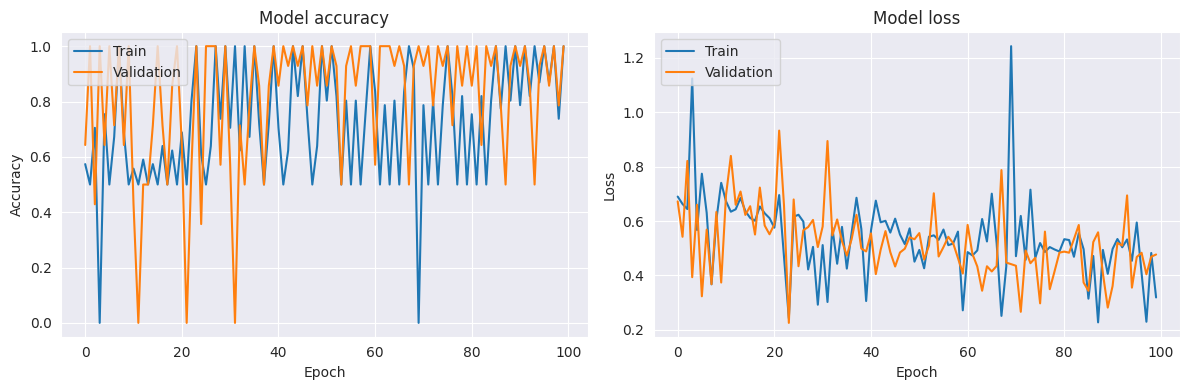

In [42]:
# Grafik oluşturur
plt.figure(figsize=(12, 4))

# Doğruluk grafiklerini çizer
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])  # Eğitim doğruluk değerlerini çizer
plt.plot(history.history['val_accuracy'])  # Doğrulama doğruluk değerlerini çizer
plt.title('Model accuracy')  # Grafik başlığı
plt.ylabel('Accuracy')  # Y ekseninin etiketi
plt.xlabel('Epoch')  # X ekseninin etiketi
plt.legend(['Train', 'Validation'], loc='upper left')  # Efsane

# Kayıp değerlerini çizer
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])  # Eğitim kayıp değerlerini çizer
plt.plot(history.history['val_loss'])  # Doğrulama kayıp değerlerini çizer
plt.title('Model loss')  # Grafik başlığı
plt.ylabel('Loss')  # Y ekseninin etiketi
plt.xlabel('Epoch')  # X ekseninin etiketi
plt.legend(['Train', 'Validation'], loc='upper left')  # Efsane

plt.tight_layout()  # Grafik düzeni ayarlar
plt.show()  # Grafikleri gösterir